In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import sys
p = Path.cwd() # set cwd
sys.path.append(str(p.parent / 'src')+"/")
import calcs, helpers, visualize

____
### 1. Load/Visualize Data:

In [2]:
# set test, ground truth cols
test_col = 'sld_aadt'
gt_col = 'test_aadt'

In [3]:
# load data
aadt_valid_df = pd.read_csv(p.parent / 'inpt_data' / 'nrel_aadt_results_06022021.csv')

# aggregate data sources - toll, tmas
aadt_valid_df['agg_source'] = aadt_valid_df['data_source'].apply(helpers.aggregate_data_sources)

# discretize continuous ground truth volume estimates
aadt_valid_df['aadt_vol_bin_wide'] = aadt_valid_df[gt_col].apply(helpers.assign_volume_range_wide)
aadt_valid_df['aadt_vol_bin_narrow'] = aadt_valid_df[gt_col].apply(helpers.assign_volume_range_narrow)

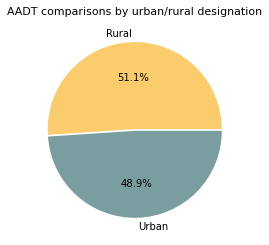

In [4]:
# urban vs. rural pie
visualize.plot_urban_rural_pie(aadt_valid_df, 
                               outpath = p.parent / 'figs' / 'comp-summaries' / 'urban_rural_pie.png')

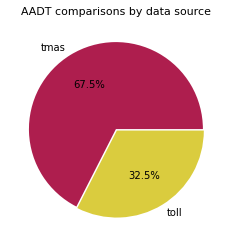

In [5]:
# data source pie
visualize.plot_data_source_pie(aadt_valid_df, 
                               outpath = p.parent / 'figs' / 'comp-summaries' / 'data_source_pie.png')

In [6]:
# create state color palette
state_comparisons_df = helpers.create_state_color_palette(aadt_valid_df)
state_palette = visualize.create_state_color_palette(state_comparisons_df)

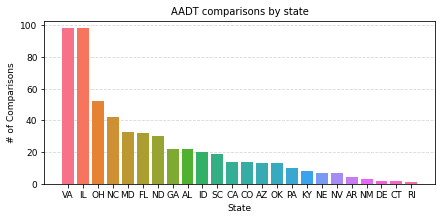

In [7]:
# comparisons by state barplot
visualize.plot_state_comparisons_bar(state_comparisons_df, 
                                     state_palette, 
                                     outpath = p.parent / 'figs' / 'comp-summaries' / 'total_comparisons_by_state.png')

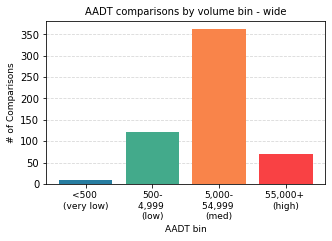

In [8]:
# comparisons by volume bin - wide barplot
visualize.plot_vol_bin_bar(aadt_valid_df, 
                           bin_type='wide',
                           gt_col=gt_col,
                           show=True, 
                           outpath = p.parent / 'figs' / 'comp-summaries' / 'total_comparisons_by_aadt_bin_wide.png')

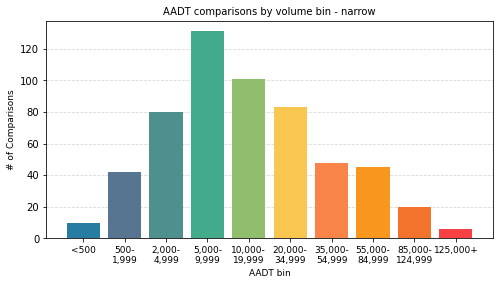

In [9]:
# comparisons by volume bin - wide barplot
visualize.plot_vol_bin_bar(aadt_valid_df, 
                           bin_type='narrow',
                           gt_col=gt_col,
                           show=True,
                           outpath = p.parent / 'figs' / 'comp-summaries' / 'total_comparisons_by_aadt_bin_narrow.png')

____
### 2. Compute Error:

In [10]:
#apply error funcs
aadt_valid_df['sld_aadt_error'] = aadt_valid_df.apply(lambda row: calcs.calc_aadt_error(row[gt_col], row[test_col]), axis=1)
aadt_valid_df['sld_aadt_abs_error'] = aadt_valid_df.apply(lambda row: calcs.calc_abs_aadt_error(row[gt_col], row[test_col]), axis=1)
aadt_valid_df['sld_aadt_pct_error'] = aadt_valid_df.apply(lambda row: calcs.calc_pct_aadt_error(row[gt_col], row[test_col]), axis=1)
aadt_valid_df['sld_aadt_abs_pct_error'] = aadt_valid_df.apply(lambda row: calcs.calc_abs_pct_aadt_error(row[gt_col], row[test_col]), axis=1)

____
### 3. Plot Error Distribution:

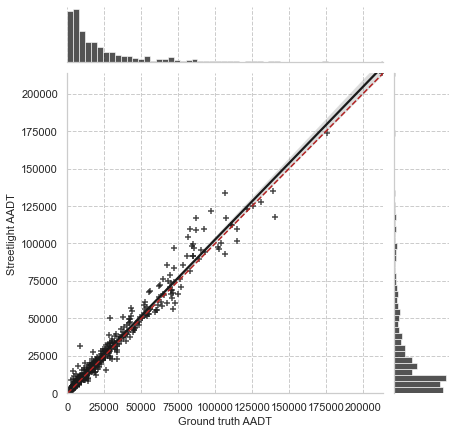

In [11]:
visualize.plot_aadt_error_scatter(aadt_valid_df, 
                                  gt_col=gt_col, 
                                  test_col=test_col, 
                                  show=True, 
                                  outpath = p.parent / 'figs' / 'comp-errors' / 'scatterplots' / 'all_comparisons.png')

Streetlight AADT estimates (y-axis) appear to match ground truth AADT well. In the plot above, the dashed red line represents the line of equality, i.e., a perfect estimator. The black regression line approximates the line of equality and falls within the 95% CI (shaded).

In [12]:
# Plots by state
%matplotlib inline
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for state in aadt_valid_df['state'].unique():
    state_aadt_valid_df = aadt_valid_df[aadt_valid_df.state==state][[gt_col, test_col]].dropna()
    max_val = max(list(state_aadt_valid_df[gt_col]) + list(state_aadt_valid_df[test_col]))
    min_val = min(list(state_aadt_valid_df[gt_col]) + list(state_aadt_valid_df[test_col]))
    
    g = sns.JointGrid()
    ax = sns.regplot(data=state_aadt_valid_df, x=gt_col, y=test_col, ax=g.ax_joint, marker='+', color=state_palette[state])
    bins = np.linspace(0, math.ceil(max_val), 30)
    ax.set_xlim(max([0, min_val - 2000]), max_val + 2000)
    ax.set_ylim(max([0, min_val - 2000]), max_val + 2000)
    sns.histplot(data=state_aadt_valid_df, x=gt_col, ax=g.ax_marg_x, bins=bins, color=state_palette[state])
    sns.histplot(data=state_aadt_valid_df, y=test_col, ax=g.ax_marg_y, bins=bins, color=state_palette[state])
    g.ax_joint.plot([0, max_val], [0, max_val], linestyle='--', c='firebrick', linewidth=1.5)
    g.set_axis_labels('Ground truth AADT', 'Streetlight AADT', fontsize=11)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'scatterplots' / 'by-state' / f'{state}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [13]:
# Plots by urban/rural
%matplotlib inline
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for urb in aadt_valid_df['urban_rural'].unique():
    urb_aadt_valid_df = aadt_valid_df[aadt_valid_df.urban_rural==urb][[gt_col, test_col]].dropna()
    max_val = max(list(urb_aadt_valid_df[gt_col]) + list(urb_aadt_valid_df[test_col]))
    min_val = min(list(urb_aadt_valid_df[gt_col]) + list(urb_aadt_valid_df[test_col]))
    g = sns.JointGrid()
    ax = sns.regplot(data=urb_aadt_valid_df, x=gt_col, y=test_col, ax=g.ax_joint, marker='+', color=visualize.urban_rural_color_dict[urb])
    bins = np.linspace(0, math.ceil(max_val), 30)
    sns.histplot(data=urb_aadt_valid_df, x=gt_col, ax=g.ax_marg_x, bins=bins, color=visualize.urban_rural_color_dict[urb])
    sns.histplot(data=urb_aadt_valid_df, y=test_col, ax=g.ax_marg_y, bins=bins, color=visualize.urban_rural_color_dict[urb])
    g.ax_joint.plot([0, max_val], [0, max_val], linestyle='--', c='firebrick', linewidth=1.5)
    g.set_axis_labels('Ground truth AADT', 'Streetlight AADT', fontsize=11)
    if max_val < 1000:
        max_val = -1000
    ax.set_xlim(max([0, min_val - 2000]), max_val + 2000)
    ax.set_ylim(max([0, min_val - 2000]), max_val + 2000)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'scatterplots' / 'by-urban-rural' / f'{urb}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [14]:
# Plots by data source
%matplotlib inline
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for src in aadt_valid_df['agg_source'].unique():
    src_aadt_valid_df = aadt_valid_df[aadt_valid_df.agg_source==src][[gt_col, test_col]].dropna()
    max_val = max(list(src_aadt_valid_df[gt_col]) + list(src_aadt_valid_df[test_col]))
    min_val = min(list(src_aadt_valid_df[gt_col]) + list(src_aadt_valid_df[test_col]))
    g = sns.JointGrid()
    ax = sns.regplot(data=src_aadt_valid_df, x=gt_col, y=test_col, ax=g.ax_joint, marker='+', color=visualize.data_source_color_dict[src])
    bins = np.linspace(0, math.ceil(max_val), 30)
    sns.histplot(data=src_aadt_valid_df, x=gt_col, ax=g.ax_marg_x, bins=bins, color=visualize.data_source_color_dict[src])
    sns.histplot(data=src_aadt_valid_df, y=test_col, ax=g.ax_marg_y, bins=bins, color=visualize.data_source_color_dict[src])
    g.ax_joint.plot([0, max_val], [0, max_val], linestyle='--', c='firebrick', linewidth=1.5)
    g.set_axis_labels('Ground truth AADT', 'Streetlight AADT', fontsize=11)
    if max_val < 1000:
        max_val = -1000
    ax.set_xlim(max([0, min_val - 2000]), max_val + 2000)
    ax.set_ylim(max([0, min_val - 2000]), max_val + 2000)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'scatterplots' / 'by-data-source' / f'{src}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [15]:
# Plots by vol bins - wide
%matplotlib inline
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for vol_bin in aadt_valid_df['aadt_vol_bin_wide'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_wide==vol_bin][[gt_col, test_col]].dropna()
    max_val = max(list(vol_aadt_valid_df[gt_col]) + list(vol_aadt_valid_df[test_col]))
    min_val = min(list(vol_aadt_valid_df[gt_col]) + list(vol_aadt_valid_df[test_col]))
    g = sns.JointGrid()
    ax = sns.regplot(data=vol_aadt_valid_df, x=gt_col, y=test_col, ax=g.ax_joint, marker='+', color=visualize.vol_range_wide_color_dict[vol_bin])
    bins = np.linspace(0, math.ceil(max_val), 30)
    sns.histplot(data=vol_aadt_valid_df, x=gt_col, ax=g.ax_marg_x, bins=bins, color=visualize.vol_range_wide_color_dict[vol_bin])
    sns.histplot(data=vol_aadt_valid_df, y=test_col, ax=g.ax_marg_y, bins=bins, color=visualize.vol_range_wide_color_dict[vol_bin])
    g.ax_joint.plot([0, max_val], [0, max_val], linestyle='--', c='firebrick', linewidth=1.5)
    g.set_axis_labels('Ground truth AADT', 'Streetlight AADT', fontsize=11)
    if max_val < 1000:
        max_val = -1000
    ax.set_xlim(max([0, min_val - 2000]), max_val + 2000)
    ax.set_ylim(max([0, min_val - 2000]), max_val + 2000)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'scatterplots' / 'by-aadt-bin-wide' / f'{vol_bin}_comparisons.png'.replace('\n',''), dpi=150, bbox_inches='tight')
    plt.close()

In [16]:
# Plots by vol bins - narrow
%matplotlib inline
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for vol_bin in aadt_valid_df['aadt_vol_bin_narrow'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_narrow==vol_bin][[gt_col, test_col]].dropna()
    max_val = max(list(vol_aadt_valid_df[gt_col]) + list(vol_aadt_valid_df[test_col]))
    min_val = min(list(vol_aadt_valid_df[gt_col]) + list(vol_aadt_valid_df[test_col]))
    g = sns.JointGrid()
    ax = sns.regplot(data=vol_aadt_valid_df, x=gt_col, y=test_col, ax=g.ax_joint, marker='+', color=visualize.vol_range_narrow_color_dict[vol_bin])
    bins = np.linspace(0, math.ceil(max_val), 30)
    sns.histplot(data=vol_aadt_valid_df, x=gt_col, ax=g.ax_marg_x, bins=bins, color=visualize.vol_range_narrow_color_dict[vol_bin])
    sns.histplot(data=vol_aadt_valid_df, y=test_col, ax=g.ax_marg_y, bins=bins, color=visualize.vol_range_narrow_color_dict[vol_bin])
    g.ax_joint.plot([0, max_val], [0, max_val], linestyle='--', c='firebrick', linewidth=1.5)
    g.set_axis_labels('Ground truth AADT', 'Streetlight AADT', fontsize=11)
    if max_val < 1000:
        max_val = -1000
    ax.set_xlim(max([0, min_val - 2000]), max_val + 2000)
    ax.set_ylim(max([0, min_val - 2000]), max_val + 2000)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'scatterplots' / 'by-aadt-bin-narrow' / f'{vol_bin}_comparisons.png'.replace('\n',''), dpi=150, bbox_inches='tight')
    plt.close()

#### 3.1.a total AADT error

mean: 1277.87 AADT
median: 649.5 AADT
skewness: 1.86
1.9% comparisons have error >15,000 AADT
0.4% comparisons have error <-15,000 AADT


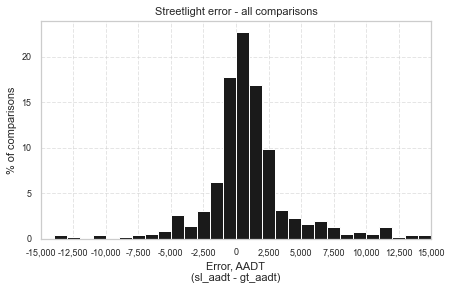

In [17]:
#AADT error - all
n = len(aadt_valid_df)
pct_errors_more_15k = len(aadt_valid_df[aadt_valid_df.sld_aadt_error > 15000]) / n * 100
pct_errors_less_neg_15k = len(aadt_valid_df[aadt_valid_df.sld_aadt_error < -15000]) / n * 100

fig, ax = plt.subplots(figsize=(7,4))
weights = np.ones_like(aadt_valid_df['sld_aadt_error'])/float(len(aadt_valid_df))* 100
plt.hist(aadt_valid_df['sld_aadt_error'], 
         bins=np.arange(-31000, 31000, 1000), 
         color='k', 
         weights=weights, 
         edgecolor='w', 
         zorder=2)

plt.xticks(np.arange(-15000, 17500, 2500), fontsize=9)
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.yticks(fontsize=9)
plt.xlabel(f'Error, AADT\n(sl_aadt - gt_aadt)', fontsize=11)
plt.ylabel('% of comparisons', fontsize=11)
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-15000, 15000)
plt.title('Streetlight error - all comparisons', fontsize=11)

print(f"mean: {round(aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
print(f"median: {round(aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
print(f"skewness: {round(stats.skew(aadt_valid_df['sld_aadt_error'].dropna()),2)}")
print(f"{round(pct_errors_more_15k,1)}% comparisons have error >15,000 AADT")
print(f"{round(pct_errors_less_neg_15k,1)}% comparisons have error <-15,000 AADT")
plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'error' / 'all_comparisons.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
#AADT error - state
%matplotlib inline

for state in aadt_valid_df['state'].unique():
    state_aadt_valid_df = aadt_valid_df[aadt_valid_df.state==state]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(state_aadt_valid_df['sld_aadt_error'])/float(len(state_aadt_valid_df))* 100
    plt.hist(state_aadt_valid_df['sld_aadt_error'], 
             bins=np.arange(-31000, 31000, 1000), 
             color=state_palette[state], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(-15000, 175000, 2500), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Error, AADT\n(sl_aadt - gt_aadt)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(-15000, 15000)
    plt.title(f'Streetlight error - {state} comparisons')

#     print(f"mean: {round(state_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(state_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(state_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'error' / 'by-state' / f'{state}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [19]:
#AADT error - urban/rural
%matplotlib inline

for urb in aadt_valid_df['urban_rural'].unique():
    urb_aadt_valid_df = aadt_valid_df[aadt_valid_df.urban_rural==urb]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(urb_aadt_valid_df['sld_aadt_error'])/float(len(urb_aadt_valid_df))* 100
    plt.hist(urb_aadt_valid_df['sld_aadt_error'], 
             bins=np.arange(-31000, 31000, 1000), 
             color=visualize.urban_rural_color_dict[urb], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(-15000, 17500, 2500), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Error, AADT\n(sl_aadt - gt_aadt)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(-15000, 15000)
    plt.title(f'Streetlight error - {urb} comparisons', fontsize=11)

#     print(f"mean: {round(urb_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(urb_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(urb_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'error' / 'by-urban-rural' / f'{urb}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [20]:
#AADT error - data source
%matplotlib inline

for src in aadt_valid_df['agg_source'].unique():
    src_aadt_valid_df = aadt_valid_df[aadt_valid_df.agg_source==src]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(src_aadt_valid_df['sld_aadt_error'])/float(len(src_aadt_valid_df))* 100
    plt.hist(src_aadt_valid_df['sld_aadt_error'], 
             bins=np.arange(-31000, 31000, 1000), 
             color=visualize.data_source_color_dict[src], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(-15000, 17500, 2500), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Error, AADT\n(sl_aadt - gt_aadt)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(-15000, 15000)
    plt.title(f'Streetlight error - {src} comparisons', fontsize=11)

#     print(f"mean: {round(urb_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(urb_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(urb_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'error' / 'by-data-source' / '{src}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [21]:
#AADT error - volume bin (wide)
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_wide'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_wide==vol_bin]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(vol_aadt_valid_df['sld_aadt_error'])/float(len(vol_aadt_valid_df))* 100
    plt.hist(vol_aadt_valid_df['sld_aadt_error'], 
             bins= np.arange(-31000, 31000, 1000), 
             color=visualize.vol_range_wide_color_dict[vol_bin], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(-15000, 17500, 2500), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Error, AADT\n(sl_aadt - gt_aadt)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(-15000, 15000)
    plt.title(f'Streetlight error - AADT bin: {vol_bin} comparisons'.replace('\n', ''), fontsize=11)

#     print(f"mean: {round(vol_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(vol_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(vol_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'error' / 'by-aadt-bin-wide' / f'{vol_bin}_comparisons.png'.replace('\n',''), dpi=150, bbox_inches='tight')
    plt.close()

In [22]:
#AADT error - volume bin (narrow)
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_narrow'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_narrow==vol_bin]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(vol_aadt_valid_df['sld_aadt_error'])/float(len(vol_aadt_valid_df))* 100
    plt.hist(vol_aadt_valid_df['sld_aadt_error'], 
             bins= np.arange(-31000, 31000, 1000), 
             color=visualize.vol_range_narrow_color_dict[vol_bin], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(-15000, 17500, 2500), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Error, AADT\n(sl_aadt - gt_aadt)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(-15000, 15000)
    plt.title(f'Streetlight error - AADT bin: {vol_bin} comparisons'.replace('\n', ''), fontsize=11)

#     print(f"mean: {round(vol_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(vol_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(vol_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'error' / 'by-aadt-bin-narrow' /f'{vol_bin}_comparisons.png'.replace('\n',''), dpi=150, bbox_inches='tight')
    plt.close()

#### 3.1.b total AADT error - CDF

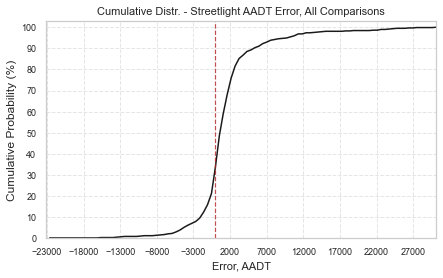

In [23]:
max_val = aadt_valid_df['sld_aadt_error'].max()
min_val = aadt_valid_df['sld_aadt_error'].min()

aadt_err_vals, aadt_err_base = np.histogram(aadt_valid_df['sld_aadt_error'], bins=np.linspace(min_val, max_val, 100))
aadt_err_cumsum = np.cumsum(aadt_err_vals)
aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)


fig, ax = plt.subplots(figsize=(7,4))
plt.plot(aadt_err_base[1:], 
         aadt_err_cum_normed * 100, 
         c='k')

xticks = math.ceil((np.linspace(min_val, max_val, 100)[1] - np.linspace(min_val, max_val, 100)[0]) * 8 / 1000) * 1000
min_xval = math.ceil(min_val / 1000) * 1000
max_xval = math.ceil(max_val / 1000) * 1000
plt.axvline(0, linestyle='--', linewidth=1.2, c='firebrick', alpha=0.8)
plt.xticks(np.arange(min_xval, max_xval, xticks), fontsize=9)
plt.yticks(np.arange(0,110,10), fontsize=9)
plt.ylim(0,103)
plt.xlim(min_val,max_val)
plt.title('Cumulative Distr. - Streetlight AADT Error, All Comparisons', fontsize=11)
plt.xlabel('Error, AADT', fontsize=11)
plt.ylabel('Cumulative Probability (%)')
plt.grid(linestyle='--', alpha=0.5)
plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'error' / 'all_comparisons.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
#AADT error - state
%matplotlib inline

for state in aadt_valid_df['state'].unique():
    state_aadt_valid_df = aadt_valid_df[aadt_valid_df.state==state]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = state_aadt_valid_df['sld_aadt_error'].max()
    min_val = state_aadt_valid_df['sld_aadt_error'].min()

    aadt_err_vals, aadt_err_base = np.histogram(state_aadt_valid_df['sld_aadt_error'], bins=np.linspace(min_val, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=state_palette[state])
    
    xticks = math.ceil((np.linspace(min_val, max_val, 100)[1] - np.linspace(min_val, max_val, 100)[0]) * 8 / 1000) * 1000
    min_xval = math.ceil(min_val / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    plt.axvline(0, linestyle='--', linewidth=1.2, c='firebrick', alpha=0.8)
    try:
        plt.xticks(np.arange(min_xval-xticks, max_xval+2*xticks, xticks), fontsize=9)
    except ZeroDivisionError:
        continue
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(min_val-500, max_val)
    plt.title(f'Cumulative Distr. - Streetlight AADT Error, {state}', fontsize=11)
    plt.xlabel('Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'error' / 'by-state' / f'{state}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close('all')

In [25]:
#AADT error - urban/rural
%matplotlib inline

for urb in aadt_valid_df['urban_rural'].unique():
    urb_aadt_valid_df = aadt_valid_df[aadt_valid_df.urban_rural==urb]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = urb_aadt_valid_df['sld_aadt_error'].max()
    min_val = urb_aadt_valid_df['sld_aadt_error'].min()

    aadt_err_vals, aadt_err_base = np.histogram(urb_aadt_valid_df['sld_aadt_error'], bins=np.linspace(min_val, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=visualize.urban_rural_color_dict[urb])
    
    xticks = math.ceil((np.linspace(min_val, max_val, 100)[1] - np.linspace(min_val, max_val, 100)[0]) * 8 / 1000) * 1000
    min_xval = math.ceil(min_val / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    plt.axvline(0, linestyle='--', linewidth=1.2, c='firebrick', alpha=0.8)
    try:
        plt.xticks(np.arange(min_xval-xticks, max_xval+2*xticks, xticks), fontsize=9)
    except ZeroDivisionError:
        continue
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(min_val-500, max_val)
    plt.title(f'Cumulative Distr. - Streetlight AADT Error, {urb}', fontsize=11)
    plt.xlabel('Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'error' / 'by-urban-rural' / f'{urb}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close('all')

In [26]:
#AADT error - data source
%matplotlib inline

for src in aadt_valid_df['agg_source'].unique():
    src_aadt_valid_df = aadt_valid_df[aadt_valid_df.agg_source==src]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = src_aadt_valid_df['sld_aadt_error'].max()
    min_val = src_aadt_valid_df['sld_aadt_error'].min()

    aadt_err_vals, aadt_err_base = np.histogram(src_aadt_valid_df['sld_aadt_error'], bins=np.linspace(min_val, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=visualize.data_source_color_dict[src])
    
    xticks = math.ceil((np.linspace(min_val, max_val, 100)[1] - np.linspace(min_val, max_val, 100)[0]) * 8 / 1000) * 1000
    min_xval = math.ceil(min_val / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    plt.axvline(0, linestyle='--', linewidth=1.2, c='firebrick', alpha=0.8)
    try:
        plt.xticks(np.arange(min_xval-xticks, max_xval+2*xticks, xticks), fontsize=9)
    except ZeroDivisionError:
        continue
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(min_val-500, max_val)
    plt.title('Cumulative Distr. - Streetlight AADT Error, {src}', fontsize=11)
    plt.xlabel('Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'error' / 'by-data-source' / f'{src}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close('all')

In [27]:
#AADT error - vol bin: wide
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_wide'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_wide==vol_bin]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = vol_aadt_valid_df['sld_aadt_error'].max()
    min_val = vol_aadt_valid_df['sld_aadt_error'].min()

    aadt_err_vals, aadt_err_base = np.histogram(vol_aadt_valid_df['sld_aadt_error'], bins=np.linspace(min_val, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=visualize.vol_range_wide_color_dict[vol_bin])
    
    xticks = math.ceil((np.linspace(min_val, max_val, 100)[1] - np.linspace(min_val, max_val, 100)[0]) * 8 / 1000) * 1000
    min_xval = math.ceil(min_val / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    plt.axvline(0, linestyle='--', linewidth=1.2, c='firebrick', alpha=0.8)
    try:
        plt.xticks(np.arange(min_xval-xticks, max_xval+2*xticks, xticks), fontsize=9)
    except ZeroDivisionError:
        continue
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(min_val-500, max_val)
    plt.title(f'Cumulative Distr. - Streetlight AADT Error, AADT bin: {vol_bin}'.replace('\n', ''), fontsize=11)
    plt.xlabel('Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'error' / 'by-aadt-bin-wide' / 'f{vol_bin}_comparisons.png'.replace('\n',''), dpi=150, bbox_inches='tight')
    plt.close('all')

In [28]:
#AADT error - vol bin: narrow
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_narrow'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_narrow==vol_bin]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = vol_aadt_valid_df['sld_aadt_error'].max()
    min_val = vol_aadt_valid_df['sld_aadt_error'].min()

    aadt_err_vals, aadt_err_base = np.histogram(vol_aadt_valid_df['sld_aadt_error'], bins=np.linspace(min_val, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=visualize.vol_range_narrow_color_dict[vol_bin])
    
    xticks = math.ceil((np.linspace(min_val, max_val, 100)[1] - np.linspace(min_val, max_val, 100)[0]) * 8 / 1000) * 1000
    min_xval = math.ceil(min_val / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    plt.axvline(0, linestyle='--', linewidth=1.2, c='firebrick', alpha=0.8)
    try:
        plt.xticks(np.arange(min_xval-xticks, max_xval+2*xticks, xticks), fontsize=9)
    except ZeroDivisionError:
        continue
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(min_val-500, max_val)
    plt.title(f'Cumulative Distr. - Streetlight AADT Error, AADT bin: {vol_bin}'.replace('\n', ''), fontsize=11)
    plt.xlabel('Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'error' / 'by-aadt-bin-narrow' / f'{vol_bin}_comparisons.png'.replace('\n',''), dpi=150, bbox_inches='tight')
    plt.close('all')

#### 3.2.a abs error

mean: 2681.83 AADT
median: 1333.5 AADT
skewness: 3.44
2.3% comparisons have |error| >15,000 AADT


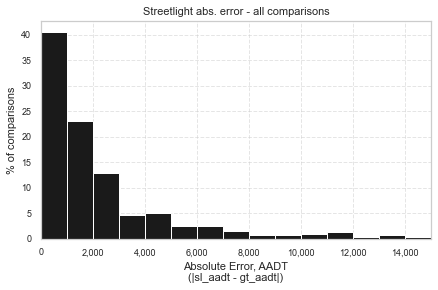

In [29]:
#AADT absolute error - all
n = len(aadt_valid_df)
pct_errors_more_15k = len(aadt_valid_df[aadt_valid_df.sld_aadt_abs_error > 15000]) / n * 100

fig, ax = plt.subplots(figsize=(7,4))
weights = np.ones_like(aadt_valid_df['sld_aadt_abs_error'])/float(len(aadt_valid_df))* 100
plt.hist(aadt_valid_df['sld_aadt_abs_error'], 
         bins= np.arange(0, 16000, 1000), 
         color='k', 
         weights=weights, 
         edgecolor='w', 
         zorder=2)

plt.xticks(np.arange(0, 16000, 2000), fontsize=9)
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.yticks(fontsize=9)
plt.xlabel(f'Absolute Error, AADT\n(|sl_aadt - gt_aadt|)', fontsize=11)
plt.ylabel('% of comparisons', fontsize=11)
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(0, 15000)
plt.title('Streetlight abs. error - all comparisons', fontsize=11)

print(f"mean: {round(aadt_valid_df['sld_aadt_abs_error'].mean(),2)} AADT")
print(f"median: {round(aadt_valid_df['sld_aadt_abs_error'].median(),2)} AADT")
print(f"skewness: {round(stats.skew(aadt_valid_df['sld_aadt_abs_error'].dropna()),2)}")
print(f"{round(pct_errors_more_15k,1)}% comparisons have |error| >15,000 AADT")
plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-error' / 'all_comparisons.png', dpi=150, bbox_inches='tight')
plt.show()

In [30]:
#AADT absolute error - state
%matplotlib inline

for state in aadt_valid_df['state'].unique():
    state_aadt_valid_df = aadt_valid_df[aadt_valid_df.state==state]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(state_aadt_valid_df['sld_aadt_abs_error'])/float(len(state_aadt_valid_df))* 100
    plt.hist(state_aadt_valid_df['sld_aadt_abs_error'], 
             bins=np.arange(0, 51000, 1000), 
             color=state_palette[state], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)
    
    plt.xticks(np.arange(0, 16000, 2000), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Absolute Error, AADT\n(|sl_aadt - gt_aadt|)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(0, 15000)
    plt.title(f'Streetlight abs. error - {state} comparisons', fontsize=11)

#     print(f"mean: {round(state_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(state_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(state_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-error' / 'by-state' / f'{state}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [31]:
#AADT absolute error - urban/rural
%matplotlib inline

for urb in aadt_valid_df['urban_rural'].unique():
    urb_aadt_valid_df = aadt_valid_df[aadt_valid_df.urban_rural==urb]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(urb_aadt_valid_df['sld_aadt_abs_error'])/float(len(urb_aadt_valid_df))* 100
    plt.hist(urb_aadt_valid_df['sld_aadt_abs_error'], 
             bins=np.arange(0, 51000, 1000), 
             color=visualize.urban_rural_color_dict[urb], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)
    
    plt.xticks(np.arange(0, 16000, 2000), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Absolute Error, AADT\n(|sl_aadt - gt_aadt|)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(0, 15000)
    plt.title(f'Streetlight abs. error - {urb} comparisons', fontsize=11)

#     print(f"mean: {round(urb_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(urb_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(urb_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-error' / 'by-urban-rural' / f'{urb}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [32]:
#AADT absolute error - data source
%matplotlib inline

for src in aadt_valid_df['agg_source'].unique():
    src_aadt_valid_df = aadt_valid_df[aadt_valid_df.agg_source==src]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(src_aadt_valid_df['sld_aadt_abs_error'])/float(len(src_aadt_valid_df))* 100
    plt.hist(src_aadt_valid_df['sld_aadt_abs_error'], 
             bins=np.arange(0, 51000, 1000), 
             color=visualize.data_source_color_dict[src], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)
    
    plt.xticks(np.arange(0, 16000, 2000), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Absolute Error, AADT\n(|sl_aadt - gt_aadt|)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(0, 15000)
    plt.title(f'Streetlight abs. error - {src} comparisons', fontsize=11)

#     print(f"mean: {round(urb_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(urb_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(urb_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-error' / 'by-data-source' / 'f{src}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [33]:
#AADT absolute error - AADT bin (wide)
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_wide'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_wide==vol_bin]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(vol_aadt_valid_df['sld_aadt_abs_error'])/float(len(vol_aadt_valid_df))* 100
    plt.hist(vol_aadt_valid_df['sld_aadt_abs_error'], 
             bins=np.arange(0, 51000, 1000), 
             color=visualize.vol_range_wide_color_dict[vol_bin], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)
    
    plt.xticks(np.arange(0, 16000, 2000), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Absolute Error, AADT\n(|sl_aadt - gt_aadt|)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(0, 15000)
    plt.title(f'Streetlight abs. error - AADT bin: {vol_bin} comparisons'.replace('\n', ''), fontsize=11)

#     print(f"mean: {round(vol_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(vol_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(vol_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-error' / 'by-aadt-bin-wide' / f'{vol_bin}_comparisons.png'.replace('\n', ''), dpi=150, bbox_inches='tight')
    plt.close()

In [34]:
#AADT absolute error - AADT bin (narrow)
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_narrow'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_narrow==vol_bin]

    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(vol_aadt_valid_df['sld_aadt_abs_error'])/float(len(vol_aadt_valid_df))* 100
    plt.hist(vol_aadt_valid_df['sld_aadt_abs_error'], 
             bins=np.arange(0, 51000, 1000), 
             color=visualize.vol_range_narrow_color_dict[vol_bin], 
             weights=weights, 
             edgecolor='w', 
             zorder=2)
    
    plt.xticks(np.arange(0, 16000, 2000), fontsize=9)
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.yticks(fontsize=9)
    plt.xlabel(f'Absolute Error, AADT\n(|sl_aadt - gt_aadt|)', fontsize=11)
    plt.ylabel('% of comparisons', fontsize=11)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(0, 15000)
    plt.title(f'Streetlight abs. error - AADT bin: {vol_bin} comparisons'.replace('\n', ''), fontsize=11)

#     print(f"mean: {round(vol_aadt_valid_df['sld_aadt_error'].mean(),2)} AADT")
#     print(f"median: {round(vol_aadt_valid_df['sld_aadt_error'].median(),2)} AADT")
#     print(f"skewness: {round(stats.skew(vol_aadt_valid_df['sld_aadt_error'].dropna()),2)}")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-error' / 'by-aadt-bin-narrow' / f'{vol_bin}_comparisons.png'.replace('\n', ''), dpi=150, bbox_inches='tight')
    plt.close()

#### 3.2.b absolute AADT error - CDF

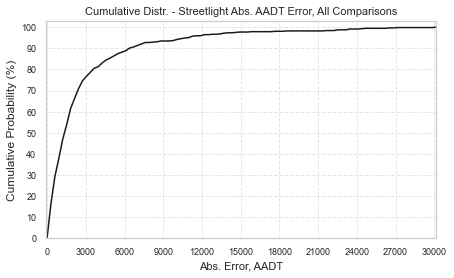

In [35]:
max_val = aadt_valid_df['sld_aadt_abs_error'].max()

aadt_err_vals, aadt_err_base = np.histogram(aadt_valid_df['sld_aadt_abs_error'], bins=np.linspace(0, max_val, 100))
aadt_err_cumsum = np.cumsum(aadt_err_vals)
aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

fig, ax = plt.subplots(figsize=(7,4))
plt.plot(aadt_err_base, 
         [0] + list(aadt_err_cum_normed * 100), 
         c='k')

xticks = math.ceil((np.linspace(0, max_val, 100)[1] - np.linspace(0, max_val, 100)[0]) * 8 / 1000) * 1000
max_xval = math.ceil(max_val / 1000) * 1000

plt.xticks(np.arange(0, max_xval, xticks), fontsize=9)
plt.yticks(np.arange(0,110,10), fontsize=9)
plt.ylim(0,103)
plt.xlim(-100, max_val)
plt.title('Cumulative Distr. - Streetlight Abs. AADT Error, All Comparisons', fontsize=11)
plt.xlabel('Abs. Error, AADT', fontsize=11)
plt.ylabel('Cumulative Probability (%)')
plt.grid(linestyle='--', alpha=0.5)
plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'abs-error' / 'all_comparisons.png', dpi=150, bbox_inches='tight')
plt.show()

In [36]:
#AADT abs error - state
%matplotlib inline

for state in aadt_valid_df['state'].unique():
    state_aadt_valid_df = aadt_valid_df[aadt_valid_df.state==state]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = state_aadt_valid_df['sld_aadt_abs_error'].max()

    aadt_err_vals, aadt_err_base = np.histogram(state_aadt_valid_df['sld_aadt_abs_error'], bins=np.linspace(0, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=state_palette[state])
    
    xticks = math.ceil((np.linspace(0, max_val, 100)[1] - np.linspace(0, max_val, 100)[0]) * 8 / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    try:
        plt.xticks(np.arange(0, max_xval, xticks), fontsize=9)
    
    except ZeroDivisionError:
        continue
        
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(-100, max_val)
    plt.title(f'Cumulative Distr. - Streetlight Abs. AADT Error, {state}', fontsize=11)
    plt.xlabel('Abs. Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'abs-error' / 'by-state' / f'{state}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close('all')

In [37]:
#AADT abs error - state
%matplotlib inline

for state in aadt_valid_df['state'].unique():
    state_aadt_valid_df = aadt_valid_df[aadt_valid_df.state==state]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = state_aadt_valid_df['sld_aadt_abs_error'].max()

    aadt_err_vals, aadt_err_base = np.histogram(state_aadt_valid_df['sld_aadt_abs_error'], bins=np.linspace(0, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=state_palette[state])
    
    xticks = math.ceil((np.linspace(0, max_val, 100)[1] - np.linspace(0, max_val, 100)[0]) * 8 / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    try:
        plt.xticks(np.arange(0, max_xval, xticks), fontsize=9)
    
    except ZeroDivisionError:
        continue
        
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(-100, max_val)
    plt.title(f'Cumulative Distr. - Streetlight Abs. AADT Error, {state}', fontsize=11)
    plt.xlabel('Abs. Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'abs-error' / 'by-state' / f'{state}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close('all')

In [38]:
#AADT abs error - urban/rural
%matplotlib inline

for urb in aadt_valid_df['urban_rural'].unique():
    urb_aadt_valid_df = aadt_valid_df[aadt_valid_df.urban_rural==urb]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = urb_aadt_valid_df['sld_aadt_abs_error'].max()

    aadt_err_vals, aadt_err_base = np.histogram(urb_aadt_valid_df['sld_aadt_abs_error'], bins=np.linspace(0, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=visualize.urban_rural_color_dict[urb])
    
    xticks = math.ceil((np.linspace(0, max_val, 100)[1] - np.linspace(0, max_val, 100)[0]) * 8 / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    try:
        plt.xticks(np.arange(0, max_xval, xticks), fontsize=9)
    
    except ZeroDivisionError:
        continue
        
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(-100, max_val)
    plt.title(f'Cumulative Distr. - Streetlight Abs. AADT Error, {urb}', fontsize=11)
    plt.xlabel('Abs. Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'abs-error' / 'by-urban-rural' / f'{urb}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close('all')

In [39]:
#AADT abs error - data source
%matplotlib inline

for src in aadt_valid_df['agg_source'].unique():
    src_aadt_valid_df = aadt_valid_df[aadt_valid_df.agg_source==src]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = src_aadt_valid_df['sld_aadt_abs_error'].max()

    aadt_err_vals, aadt_err_base = np.histogram(src_aadt_valid_df['sld_aadt_abs_error'], bins=np.linspace(0, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=visualize.data_source_color_dict[src])
    
    xticks = math.ceil((np.linspace(0, max_val, 100)[1] - np.linspace(0, max_val, 100)[0]) * 8 / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    try:
        plt.xticks(np.arange(0, max_xval, xticks), fontsize=9)
    
    except ZeroDivisionError:
        continue
        
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(-100, max_val)
    plt.title(f'Cumulative Distr. - Streetlight Abs. AADT Error, {src}', fontsize=11)
    plt.xlabel('Abs. Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'abs-error' / 'by-data-source' / f'{src}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close('all')

In [40]:
#AADT abs error - wide AADT bins
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_wide'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_wide==vol_bin]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = src_aadt_valid_df['sld_aadt_abs_error'].max()

    aadt_err_vals, aadt_err_base = np.histogram(vol_aadt_valid_df['sld_aadt_abs_error'], bins=np.linspace(0, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=visualize.vol_range_wide_color_dict[vol_bin])
    
    xticks = math.ceil((np.linspace(0, max_val, 100)[1] - np.linspace(0, max_val, 100)[0]) * 8 / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    try:
        plt.xticks(np.arange(0, max_xval, xticks), fontsize=9)
    
    except ZeroDivisionError:
        continue
        
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(-100, max_val)
    plt.title(f'Cumulative Distr. - Streetlight Abs. AADT Error, AADT bin: {vol_bin}'.replace('\n', ''), fontsize=11)
    plt.xlabel('Abs. Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'abs-error' / 'by-aadt-bin-wide' / f'{vol_bin}_comparisons.png'.replace('\n', ''), dpi=150, bbox_inches='tight')
    plt.close('all')

In [41]:
#AADT abs error - narrow AADT bins
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_narrow'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_narrow==vol_bin]

    fig, ax = plt.subplots(figsize=(7,4))
    max_val = src_aadt_valid_df['sld_aadt_abs_error'].max()

    aadt_err_vals, aadt_err_base = np.histogram(vol_aadt_valid_df['sld_aadt_abs_error'], bins=np.linspace(0, max_val, 100))
    aadt_err_cumsum = np.cumsum(aadt_err_vals)
    aadt_err_cum_normed = aadt_err_cumsum / max(aadt_err_cumsum)

    plt.figure(figsize=(7,4))
    plt.plot(aadt_err_base, 
             [0] + list(aadt_err_cum_normed * 100), 
             c=visualize.vol_range_narrow_color_dict[vol_bin])
    
    xticks = math.ceil((np.linspace(0, max_val, 100)[1] - np.linspace(0, max_val, 100)[0]) * 8 / 1000) * 1000
    max_xval = math.ceil(max_val / 1000) * 1000

    try:
        plt.xticks(np.arange(0, max_xval, xticks), fontsize=9)
    
    except ZeroDivisionError:
        continue
        
    plt.yticks(np.arange(0,110,10), fontsize=9)
    plt.ylim(0,103)
    plt.xlim(-100, max_val)
    plt.title(f'Cumulative Distr. - Streetlight Abs. AADT Error, AADT bin: {vol_bin}'.replace('\n', ''), fontsize=11)
    plt.xlabel('Abs. Error, AADT', fontsize=11)
    plt.ylabel('Cumulative Probability (%)')
    plt.grid(linestyle='--', alpha=0.5)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'cdfs' / 'abs-error' / 'by-aadt-bin-narrow' / f'{vol_bin}_comparisons.png'.replace('\n', ''), dpi=150, bbox_inches='tight')
    plt.close('all')

#### 3.3 percent error

In [42]:
for pctile in np.arange(0, 1.1, 0.1):
    pctile_val = aadt_valid_df['sld_aadt_pct_error'].quantile(pctile)
    print(f"{int(pctile*100)}%-tile: {round(pctile_val*100,2)}% error")

0%-tile: -72.97% error
10%-tile: -11.85% error
20%-tile: -5.33% error
30%-tile: -1.46% error
40%-tile: 2.02% error
50%-tile: 5.66% error
60%-tile: 11.61% error
70%-tile: 17.38% error
80%-tile: 26.13% error
90%-tile: 35.56% error
100%-tile: 321.13% error


mean: 11.73 %
median: 5.66 %
skewness: 4.32
1.2% comparisons have % error >100%
0.0% comparisons have % error <-100%


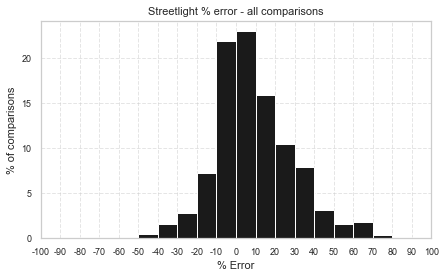

In [43]:
#AADT pct error - all
n = len(aadt_valid_df)
pct_errors_more_100 = len(aadt_valid_df[aadt_valid_df.sld_aadt_pct_error > 1]) / n * 100
pct_errors_less_neg_100 = len(aadt_valid_df[aadt_valid_df.sld_aadt_pct_error < -1]) / n * 100

fig, ax = plt.subplots(figsize=(7,4))
weights = np.ones_like(aadt_valid_df['sld_aadt_pct_error'])/float(len(aadt_valid_df)) * 100
plt.hist(aadt_valid_df['sld_aadt_pct_error'] * 100, 
         bins=np.arange(-110, 100, 10), 
         color='k', 
         weights=weights, 
         edgecolor='w', 
         zorder=2)

plt.xticks(np.arange(-100, 110, 10), fontsize=9)
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.yticks(fontsize=9)
plt.xlabel(f'% Error', fontsize=11)
plt.ylabel('% of comparisons', fontsize=11)
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-100, 100)
plt.title('Streetlight % error - all comparisons', fontsize=11)

print(f"mean: {round(aadt_valid_df['sld_aadt_pct_error'].mean()*100, 2)} %")
print(f"median: {round(aadt_valid_df['sld_aadt_pct_error'].median()*100, 2)} %")
print(f"skewness: {round(stats.skew(aadt_valid_df['sld_aadt_pct_error'].dropna()),2)}")
print(f"{round(pct_errors_more_100,1)}% comparisons have % error >100%")
print(f"{round(pct_errors_less_neg_100,1)}% comparisons have % error <-100%")
plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'pct-error' / 'all_comparisons.png', dpi=150, bbox_inches='tight')
plt.show()

#### 3.4. absolute percent error

mean: 18.8%
median: 11.8%
1.2% comparisons have |error| >100%


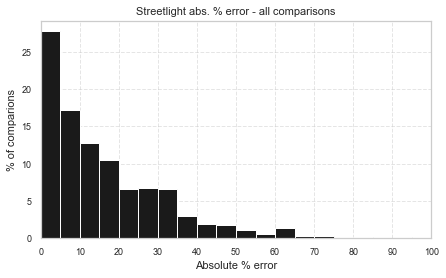

In [44]:
#AADT absolute pct error - all
n = len(aadt_valid_df)
pct_errors_more_100 = len(aadt_valid_df[aadt_valid_df.sld_aadt_abs_pct_error > 1]) / n * 100
pct_error = aadt_valid_df['sld_aadt_abs_pct_error'] * 100

fig, ax = plt.subplots(figsize=(7,4))
weights = np.ones_like(pct_error)/float(len(pct_error))* 100
plt.hist(pct_error, 
         bins= np.arange(0, 105, 5), 
         weights=weights, 
         color='k', 
         edgecolor='w', 
         zorder=2)

plt.xticks(np.arange(0, 110, 10), fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel('Absolute % error', fontsize=11)
plt.ylabel('% of comparions', fontsize=11)
plt.xlim(0,100)
plt.grid(linestyle='--', alpha=0.5)
plt.title(f'Streetlight abs. % error - all comparisons', fontsize=11)

print(f"mean: {round(pct_error.mean(),1)}%")
print(f"median: {round(pct_error.median(),1)}%")
print(f"{round(pct_errors_more_100,1)}% comparisons have |error| >100%")
plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-pct-error' / 'all_comparisons.png', dpi=150, bbox_inches='tight')
plt.show()

In [45]:
#AADT absolute pct error - state
%matplotlib inline

for state in aadt_valid_df['state'].unique():
    state_aadt_valid_df = aadt_valid_df[aadt_valid_df.state==state]

    n = len(state_aadt_valid_df)
    pct_errors_more_100 = len(state_aadt_valid_df[state_aadt_valid_df.sld_aadt_abs_pct_error > 1]) / n * 100
    pct_error = state_aadt_valid_df['sld_aadt_abs_pct_error'] * 100
    
    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(pct_error)/float(len(pct_error))* 100
    plt.hist(pct_error, 
             bins= np.arange(0, 105, 5), 
             weights=weights, 
             color=state_palette[state], 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(0, 110, 10), fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlabel('Absolute % error', fontsize=11)
    plt.ylabel('% of comparions', fontsize=11)
    plt.xlim(0,100)
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(f'Streetlight abs. % error - {state} comparisons', fontsize=11)

#     print(f"mean: {round(pct_error.mean(),1)}%")
#     print(f"median: {round(pct_error.median(),1)}%")
#     print(f"{round(pct_errors_more_100,1)}% comparisons have |error| >100%")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-pct-error' / 'by-state' / f'{state}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [46]:
#AADT absolute pct error - urban/rural
%matplotlib inline

for urb in aadt_valid_df['urban_rural'].unique():
    urb_aadt_valid_df = aadt_valid_df[aadt_valid_df.urban_rural==urb]

    n = len(urb_aadt_valid_df)
    pct_errors_more_100 = len(urb_aadt_valid_df[urb_aadt_valid_df.sld_aadt_abs_pct_error > 1]) / n * 100
    pct_error = urb_aadt_valid_df['sld_aadt_abs_pct_error'] * 100
    
    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(pct_error)/float(len(pct_error))* 100
    plt.hist(pct_error, 
             bins= np.arange(0, 105, 5), 
             weights=weights, 
             color=visualize.urban_rural_color_dict[urb], 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(0, 110, 10), fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlabel('Absolute % error', fontsize=11)
    plt.ylabel('% of comparions', fontsize=11)
    plt.xlim(0,100)
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(f'Streetlight abs. % error - {urb} comparisons', fontsize=11)

#     print(f"mean: {round(pct_error.mean(),1)}%")
#     print(f"median: {round(pct_error.median(),1)}%")
#     print(f"{round(pct_errors_more_100,1)}% comparisons have |error| >100%")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-pct-error' / 'by-urban-rural' / f'{urb}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [47]:
#AADT absolute pct error - data source
%matplotlib inline

for src in aadt_valid_df['agg_source'].unique():
    src_aadt_valid_df = aadt_valid_df[aadt_valid_df.agg_source==src]

    n = len(src_aadt_valid_df)
    pct_errors_more_100 = len(src_aadt_valid_df[src_aadt_valid_df.sld_aadt_abs_pct_error > 1]) / n * 100
    pct_error = src_aadt_valid_df['sld_aadt_abs_pct_error'] * 100
    
    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(pct_error)/float(len(pct_error))* 100
    plt.hist(pct_error, 
             bins= np.arange(0, 105, 5), 
             weights=weights, 
             color=visualize.data_source_color_dict[src], 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(0, 110, 10), fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlabel('Absolute % error', fontsize=11)
    plt.ylabel('% of comparions', fontsize=11)
    plt.xlim(0,100)
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(f'Streetlight abs. % error - {urb} comparisons', fontsize=11)

#     print(f"mean: {round(pct_error.mean(),1)}%")
#     print(f"median: {round(pct_error.median(),1)}%")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-pct-error' / 'by-data-source' / f'{src}_comparisons.png', dpi=150, bbox_inches='tight')
    plt.close()

In [48]:
#AADT absolute pct error - volume (wide)
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_wide'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_wide==vol_bin]

    n = len(vol_aadt_valid_df)
    pct_errors_more_100 = len(vol_aadt_valid_df[vol_aadt_valid_df.sld_aadt_abs_pct_error > 1]) / n * 100
    pct_error = vol_aadt_valid_df['sld_aadt_abs_pct_error'] * 100
    
    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(pct_error)/float(len(pct_error))* 100
    plt.hist(pct_error, 
             bins=np.arange(0, 105, 5), 
             weights=weights, 
             color=visualize.vol_range_wide_color_dict[vol_bin], 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(0, 110, 10), fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlabel('Absolute % error', fontsize=11)
    plt.ylabel('% of comparions', fontsize=11)
    plt.xlim(0,100)
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(f'Streetlight abs. % error - AADT bin: {vol_bin} comparisons'.replace('\n', ''), fontsize=11)

#     print(f"mean: {round(pct_error.mean(),1)}%")
#     print(f"median: {round(pct_error.median(),1)}%")
#     print(f"{round(pct_errors_more_100,1)}% comparisons have |error| >100%")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-pct-error' / 'by-aadt-bin-wide' / f'{vol_bin}_comparisons.png'.replace('\n', ''), dpi=150, bbox_inches='tight')
    plt.close()

In [49]:
#AADT absolute pct error - volume (narrow)
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_narrow'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_narrow==vol_bin]

    n = len(vol_aadt_valid_df)
    pct_errors_more_100 = len(vol_aadt_valid_df[vol_aadt_valid_df.sld_aadt_abs_pct_error > 1]) / n * 100
    pct_error = vol_aadt_valid_df['sld_aadt_abs_pct_error'] * 100
    
    fig, ax = plt.subplots(figsize=(7,4))
    weights = np.ones_like(pct_error)/float(len(pct_error))* 100
    plt.hist(pct_error, bins= np.arange(0, 105, 5), 
             weights=weights, 
             color=visualize.vol_range_narrow_color_dict[vol_bin], 
             edgecolor='w', 
             zorder=2)

    plt.xticks(np.arange(0, 110, 10), fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlabel('Absolute % error', fontsize=11)
    plt.ylabel('% of comparions', fontsize=11)
    plt.xlim(0,100)
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(f'Streetlight abs. % error - AADT bin: {vol_bin} comparisons'.replace('\n', ''), fontsize=11)

#     print(f"mean: {round(pct_error.mean(),1)}%")
#     print(f"median: {round(pct_error.median(),1)}%")
#     print(f"{round(pct_errors_more_100,1)}% comparisons have |error| >100%")
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'histograms' / 'abs-pct-error' / 'by-aadt-bin-narrow' / f'{vol_bin}_comparisons.png'.replace('\n', ''), dpi=150, bbox_inches='tight')
    plt.close()

#### 3.5 RMSE, MAPE, MdAPE

In [50]:
print(f"RMSE: {round((aadt_valid_df.sld_aadt_error**2).mean()**(1/2), 1)} AADT")
print(f"MAPE: {round(aadt_valid_df['sld_aadt_abs_pct_error'].mean()*100,1)}%")
print(f"MdAPE: {round(aadt_valid_df['sld_aadt_abs_pct_error'].median()*100,1)}%")

RMSE: 4913.9 AADT
MAPE: 18.8%
MdAPE: 11.8%


____
### 4. Break out Metrics for Table:

In [51]:
print("all comparisons:")
print("-"*20)

compare_df = aadt_valid_df.dropna(subset=[gt_col, test_col])
print(f"n: {len(compare_df)}")
print()
print(f"2.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.025), 2)}")
print()
print(f"16 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.16), 2)}")
print()
print(f"50 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.5), 2)}")
print()
print(f"84 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.84), 2)}")
print()
print(f"97.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.975), 2)}")
print()
print(f"median % AADT error: {round(compare_df.sld_aadt_pct_error.median()*100, 2)}")
print()
print(f"mean % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.mean()*100, 2)}")
print()
print(f"median % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.median()*100, 2)}")
print()
print(f"NRMSE: {round(((compare_df.sld_aadt_error**2).mean()**(1/2)) / (compare_df['sld_aadt_error'].max() - compare_df['sld_aadt_error'].min()), 2)}")
print()
print(f"Spearman's rho: {stats.spearmanr(compare_df[gt_col], compare_df[test_col])[0]}, p={stats.spearmanr(compare_df[gt_col], compare_df[test_col])[1]}")
print()
corr_df = compare_df[[gt_col, test_col]].dropna()
print(f"Wilcoxon signed rank test (p-value): {stats.wilcoxon(corr_df[gt_col], corr_df[test_col])[1]}")
print()
print(f"Paired sample t-test (p-value): {stats.ttest_rel(corr_df[gt_col], corr_df[test_col])[1]}")
print()
print()

for urb in aadt_valid_df['urban_rural'].unique():
    print(f"{urb} comparisons:")
    print("-"*20)
    
    compare_df = aadt_valid_df[aadt_valid_df.urban_rural==urb].dropna(subset=[gt_col, test_col])
    print(f"n: {len(compare_df)}")
    print()
    print(f"2.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.025), 2)}")
    print()
    print(f"16 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.16), 2)}")
    print()
    print(f"50 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.5), 2)}")
    print()
    print(f"84 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.84), 2)}")
    print()
    print(f"97.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.975), 2)}")
    print()
    print(f"median % AADT error: {round(compare_df.sld_aadt_pct_error.median()*100, 2)}")
    print()
    print(f"mean % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.mean()*100, 2)}")
    print()
    print(f"median % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.median()*100, 2)}")
    print()
    print(f"NRMSE: {round(((compare_df.sld_aadt_error**2).mean()**(1/2)) / (compare_df['sld_aadt_error'].max() - compare_df['sld_aadt_error'].min()), 2)}")
    print()
    print(f"Spearman's rho: {stats.spearmanr(compare_df[gt_col], compare_df[test_col])[0]}, p={stats.spearmanr(compare_df[gt_col], compare_df[test_col])[1]}")
    print()
    corr_df = compare_df[[gt_col, test_col]].dropna()
    print(f"Wilcoxon signed rank test (p-value): {stats.wilcoxon(corr_df[gt_col], corr_df[test_col])[1]}")
    print()
    print(f"Paired sample t-test (p-value): {stats.ttest_rel(corr_df[gt_col], corr_df[test_col])[1]}")
    print()
    print()
    
aadt_bins = aadt_valid_df.sort_values(gt_col)['aadt_vol_bin_wide'].unique()
for vol in aadt_bins:
    vol_name = vol.replace('\n', '')
    print(f"wide: {vol_name} comparisons:")
    print("-"*20)
    
    compare_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_wide==vol].dropna(subset=[gt_col, test_col])
    print(f"n: {len(compare_df)}")
    print()
    print(f"2.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.025), 2)}")
    print()
    print(f"16 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.16), 2)}")
    print()
    print(f"50 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.5), 2)}")
    print()
    print(f"84 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.84), 2)}")
    print()
    print(f"97.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.975), 2)}")
    print()
    print(f"median % AADT error: {round(compare_df.sld_aadt_pct_error.median()*100, 2)}")
    print()
    print(f"mean % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.mean()*100, 2)}")
    print()
    print(f"median % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.median()*100, 2)}")
    print()
    print(f"NRMSE: {round(((compare_df.sld_aadt_error**2).mean()**(1/2)) / (compare_df['sld_aadt_error'].max() - compare_df['sld_aadt_error'].min()), 2)}")
    print()
    print(f"Spearman's rho: {stats.spearmanr(compare_df[gt_col], compare_df[test_col])[0]}, p={stats.spearmanr(compare_df[gt_col], compare_df[test_col])[1]}")
    print()
    corr_df = compare_df[[gt_col, test_col]].dropna()
    print(f"Wilcoxon signed rank test (p-value): {stats.wilcoxon(corr_df[gt_col], corr_df[test_col])[1]}")
    print()
    print(f"Paired sample t-test (p-value): {stats.ttest_rel(corr_df[gt_col], corr_df[test_col])[1]}")
    print()
    print()
    
for src in aadt_valid_df['agg_source'].unique():
    print(f"source: {src} comparisons:")
    print("-"*20)
    
    compare_df = aadt_valid_df[aadt_valid_df.agg_source==src].dropna(subset=[gt_col, test_col])
    print(f"n: {len(compare_df)}")
    print()
    print(f"2.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.025), 2)}")
    print()
    print(f"16 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.16), 2)}")
    print()
    print(f"50 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.5), 2)}")
    print()
    print(f"84 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.84), 2)}")
    print()
    print(f"97.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.975), 2)}")
    print()
    print(f"median % AADT error: {round(compare_df.sld_aadt_pct_error.median()*100, 2)}")
    print()
    print(f"mean % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.mean()*100, 2)}")
    print()
    print(f"median % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.median()*100, 2)}")
    print()
    print(f"NRMSE: {round(((compare_df.sld_aadt_error**2).mean()**(1/2)) / (compare_df['sld_aadt_error'].max() - compare_df['sld_aadt_error'].min()), 2)}")
    print()
    print(f"Spearman's rho: {stats.spearmanr(compare_df[gt_col], compare_df[test_col])[0]}, p={stats.spearmanr(compare_df[gt_col], compare_df[test_col])[1]}")
    print()
    corr_df = compare_df[[gt_col, test_col]].dropna()
    print(f"Wilcoxon signed rank test (p-value): {stats.wilcoxon(corr_df[gt_col], corr_df[test_col])[1]}")
    print()
    print(f"Paired sample t-test (p-value): {stats.ttest_rel(corr_df[gt_col], corr_df[test_col])[1]}")
    print()
    print()
    
for withheld in aadt_valid_df['SLD_withheld'].unique():
    print(f"SLD_withheld={withheld} comparisons:")
    print("-"*20)
    
    compare_df = aadt_valid_df[aadt_valid_df['SLD_withheld']==withheld].dropna(subset=[gt_col, test_col])
    print(f"n: {len(compare_df)}")
    print()
    print(f"2.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.025), 2)}")
    print()
    print(f"16 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.16), 2)}")
    print()
    print(f"50 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.5), 2)}")
    print()
    print(f"84 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.84), 2)}")
    print()
    print(f"97.5 pct-tile AADT error: {round(compare_df.sld_aadt_error.quantile(0.975), 2)}")
    print()
    print(f"median % AADT error: {round(compare_df.sld_aadt_pct_error.median()*100, 2)}")
    print()
    print(f"mean % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.mean()*100, 2)}")
    print()
    print(f"median % abs. AADT error: {round(compare_df.sld_aadt_abs_pct_error.median()*100, 2)}")
    print()
    print(f"NRMSE: {round(((compare_df.sld_aadt_error**2).mean()**(1/2)) / (compare_df['sld_aadt_error'].max() - compare_df['sld_aadt_error'].min()), 2)}")
    print()
    print(f"Spearman's rho: {stats.spearmanr(compare_df[gt_col], compare_df[test_col])[0]}, p={stats.spearmanr(compare_df[gt_col], compare_df[test_col])[1]}")
    print()
    corr_df = compare_df[[gt_col, test_col]].dropna()
    print(f"Wilcoxon signed rank test (p-value): {stats.wilcoxon(corr_df[gt_col], corr_df[test_col])[1]}")
    print()
    print(f"Paired sample t-test (p-value): {stats.ttest_rel(corr_df[gt_col], corr_df[test_col])[1]}")
    print()
    print()

all comparisons:
--------------------
n: 566

2.5 pct-tile AADT error: -5767.5

16 pct-tile AADT error: -1068.4

50 pct-tile AADT error: 649.5

84 pct-tile AADT error: 3031.6

97.5 pct-tile AADT error: 13285.38

median % AADT error: 5.66

mean % abs. AADT error: 18.77

median % abs. AADT error: 11.75

NRMSE: 0.09

Spearman's rho: 0.9834155199387404, p=0.0

Wilcoxon signed rank test (p-value): 2.1789125693738026e-16

Paired sample t-test (p-value): 3.234069178447211e-10


rural comparisons:
--------------------
n: 289

2.5 pct-tile AADT error: -5702.6

16 pct-tile AADT error: -836.56

50 pct-tile AADT error: 199.0

84 pct-tile AADT error: 1978.76

97.5 pct-tile AADT error: 5263.6

median % AADT error: 3.61

mean % abs. AADT error: 16.25

median % abs. AADT error: 11.59

NRMSE: 0.08

Spearman's rho: 0.9881530088658227, p=1.1696729889392433e-235

Wilcoxon signed rank test (p-value): 9.264255822871451e-05

Paired sample t-test (p-value): 0.044628396158061655


urban comparisons:
----------

____
### 5. Normality Testing

#### 5.1 Q-Q Plot 
Quantile-Quantile (Q-Q) plots are scatterplots comparing the quantiles (percentiles) of our data (here, estimation errors) against a desired distribution (here, normal distr.). 

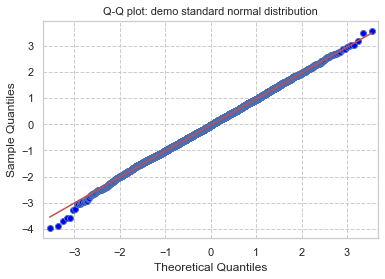

In [52]:
fig = sm.qqplot(np.random.normal(0,1,5000), line='s')
plt.title('Q-Q plot: demo standard normal distribution', fontsize=11)
plt.savefig(p.parent / 'figs' / 'comp-errors' / 'q-q-plots' / 'demo_standard_normal.png'.replace('\n', ''), dpi=150, bbox_inches='tight') 
plt.show()

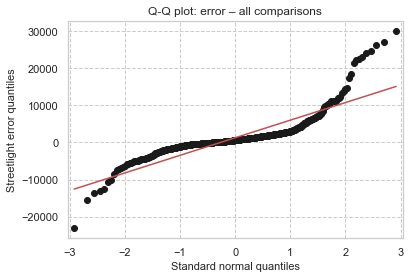

In [53]:
#Q-Q plot - all
fig=sm.qqplot(aadt_valid_df['sld_aadt_error'], line='s', markerfacecolor='k', markeredgecolor='k')
plt.title('Q-Q plot: error – all comparisons')
plt.xlabel('Standard normal quantiles', fontsize=11)
plt.ylabel('Streetlight error quantiles', fontsize=11)
plt.savefig(p.parent / 'figs' / 'comp-errors' / 'q-q-plots' / 'all_comparisons.png', dpi=150, bbox_inches='tight')   
plt.show()

In [54]:
#Q-Q plot - state
%matplotlib inline

for state in aadt_valid_df['state'].unique():
    state_aadt_valid_df = aadt_valid_df[aadt_valid_df.state==state]
    
    fig=sm.qqplot(state_aadt_valid_df['sld_aadt_error'], 
                  line='s', 
                  markerfacecolor=state_palette[state], 
                  markeredgecolor=state_palette[state])
    plt.title(f'Q-Q plot: error – {state} comparisons'.replace('\n', ''))
    plt.xlabel('Standard normal quantiles', fontsize=11)
    plt.ylabel('Streetlight error quantiles', fontsize=11)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'q-q-plots' / 'by-state' / f'{state}_comparisons.png', dpi=150, bbox_inches='tight')   
    plt.close()   

In [55]:
#Q-Q plot - urban/rural
%matplotlib inline

for urb in aadt_valid_df['urban_rural'].unique():
    urb_aadt_valid_df = aadt_valid_df[aadt_valid_df.urban_rural==urb]
    
    fig=sm.qqplot(urb_aadt_valid_df['sld_aadt_error'], 
                  line='s', 
                  markerfacecolor=visualize.urban_rural_color_dict[urb], 
                  markeredgecolor=visualize.urban_rural_color_dict[urb])
    plt.title(f'Q-Q plot: error – {urb} comparisons'.replace('\n', ''))
    plt.xlabel('Standard normal quantiles', fontsize=11)
    plt.ylabel('Streetlight error quantiles', fontsize=11)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'q-q-plots' / 'by-urban-rural' / f'{urb}_comparisons.png', dpi=150, bbox_inches='tight')   
    plt.close()   

In [56]:
#Q-Q plot - data source
%matplotlib inline

for src in aadt_valid_df['agg_source'].unique():
    src_aadt_valid_df = aadt_valid_df[aadt_valid_df.agg_source==src]
    
    fig=sm.qqplot(src_aadt_valid_df['sld_aadt_error'], 
                  line='s', 
                  markerfacecolor=visualize.data_source_color_dict[src], 
                  markeredgecolor=visualize.data_source_color_dict[src])
    plt.title(f'Q-Q plot: error – {src} comparisons'.replace('\n', ''))
    plt.xlabel('Standard normal quantiles', fontsize=11)
    plt.ylabel('Streetlight error quantiles', fontsize=11)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'q-q-plots' / 'by-data-source' / f'{src}_comparisons.png', dpi=150, bbox_inches='tight')   
    plt.close()   

In [57]:
#Q-Q plot - volume (wide)
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_wide'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_wide==vol_bin]
    
    fig=sm.qqplot(vol_aadt_valid_df['sld_aadt_error'], 
                  line='s', 
                  markerfacecolor=visualize.vol_range_wide_color_dict[vol_bin], 
                  markeredgecolor=visualize.vol_range_wide_color_dict[vol_bin])
    plt.title(f'Q-Q plot: error – AADT bin: {vol_bin} comparisons'.replace('\n', ''))
    plt.xlabel('Standard normal quantiles', fontsize=11)
    plt.ylabel('Streetlight error quantiles', fontsize=11)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'q-q-plots' / 'by-aadt-bin-wide' / f'{vol_bin}_comparisons.png'.replace('\n', ''), dpi=150, bbox_inches='tight')   
    plt.close()   

In [58]:
#Q-Q plot - volume (narrow)
%matplotlib inline

for vol_bin in aadt_valid_df['aadt_vol_bin_narrow'].unique():
    vol_aadt_valid_df = aadt_valid_df[aadt_valid_df.aadt_vol_bin_narrow==vol_bin]
    
    fig=sm.qqplot(vol_aadt_valid_df['sld_aadt_error'], 
                  line='s', 
                  markerfacecolor=visualize.vol_range_narrow_color_dict[vol_bin], 
                  markeredgecolor=visualize.vol_range_narrow_color_dict[vol_bin])
    plt.title(f'Q-Q plot: error – AADT bin: {vol_bin} comparisons'.replace('\n', ''))
    plt.xlabel('Standard normal quantiles', fontsize=11)
    plt.ylabel('Streetlight error quantiles', fontsize=11)
    plt.savefig(p.parent / 'figs' / 'comp-errors' / 'q-q-plots' / 'by-aadt-bin-narrow' / f'{vol_bin}_comparisons.png'.replace('\n', ''), dpi=150, bbox_inches='tight')   
    plt.close()   

#### 5.2 KS-Test:
One-sample Kolmogorov-Smirnov goodness of fit test, tests the distribution of an ovserved random variable against a given distribution (here, the normal distribution). Under the null hypothesis, the two distributions are the same. 

In [59]:
stats.kstest(aadt_valid_df['sld_aadt_error'].dropna(), 'norm')

KstestResult(statistic=0.6572121450125838, pvalue=3.5612727273798813e-240)

#### 5.3 Shapiro-Wilk Test: 
Shapiro-Wilk test for normality tests the null hypothesis that the data was drawn from a normal distribution.

In [60]:
stats.shapiro(aadt_valid_df['sld_aadt_error'].dropna())

ShapiroResult(statistic=0.7568528652191162, pvalue=4.8264223296107035e-28)

In both Kolmogorov-Smirnov and Shapiro-Wilk tests for normality of aadt_error, p << 0.05, therefore reject null hypothesis: Error is not normally distributed.

____
**Assessment**: Error is normally distributed? Yes / **No**
____

### 6. Correlation Analysis
**Pearson r** - measures linear relationship between two data sets. Strictly speaking, Pearson's correlation coefficient requires that each data set be normally distributed. Values vary from -1 to 1 with 0 implying no correlation. Correlations of -1 or 1 imply an exact linear relationship.  
  
**Spearman rho** - rank-order correlation coefficient that is a nonparametric measure of the monotonicity of the relationship between two data sets. Unlike the Pearson correlation, Spearman correlation does not assume that both data sets are normally distributed. Values vary from -1 to 1 with 0 implying no correlation. Correlations of -1 or 1 imply an exact monotonic relationship.

In [61]:
#Correlation (returns (corr coeff., 2-tailed p-value))
corr_df = aadt_valid_df[[gt_col, test_col]].dropna()

print("Pearson's r (parametric):")
print(f"r={stats.pearsonr(corr_df[gt_col], corr_df[test_col])[0]}, p={stats.pearsonr(corr_df[gt_col], corr_df[test_col])[1]}")
print()
print("Spearman's rho (nonparametric):")
print(f"r={stats.spearmanr(corr_df[gt_col], corr_df[test_col])[0]}, p={stats.spearmanr(corr_df[gt_col], corr_df[test_col])[1]}")

Pearson's r (parametric):
r=0.9867617156741583, p=0.0

Spearman's rho (nonparametric):
r=0.9834155199387404, p=0.0


----
### 7. Hypthothesis Testing  
**Paired Sample t-test** - Parametric test that determines whether the mean difference between two sets of observations is zero. The paired sample t-test is commonly used to test the statistical difference between paired measurements. The null hypothesis assumes that the true mean difference is equal to zero.  
  
**Wilcoxon Signed-Rank Test** – Non-parametric test used to compare two related (matched) samples to determine whether their population mean ranks differ. It can be used as an alternative to the paired sample t-test when the distribution of the difference between the two samples' means cannot be assumed to be normally distributed.

In [62]:
# paired Sample t-test - all
corr_df = aadt_valid_df[[gt_col, test_col]].dropna()
stats.ttest_rel(corr_df[gt_col], corr_df[test_col])

Ttest_relResult(statistic=-6.401619055570713, pvalue=3.234069178447211e-10)

In [63]:
# Wilcoxon signed-rank test - all
corr_df = aadt_valid_df[[gt_col, test_col]].dropna()
stats.wilcoxon(corr_df[gt_col], corr_df[test_col])

WilcoxonResult(statistic=48267.5, pvalue=2.1789125693738026e-16)

____
**Assessment:** p-value << 0.05, therefore reject null hypothesis that mean difference between samples is zero
____

### 8. Quantile Regression:

In [64]:
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

mod = smf.quantreg(f'{test_col} ~ {gt_col}', corr_df)
res = mod.fit(q=0.5) #median: q=0.5
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:               sld_aadt   Pseudo R-squared:               0.8586
Model:                       QuantReg   Bandwidth:                       1085.
Method:                 Least Squares   Sparsity:                        4355.
Date:                Wed, 30 Jun 2021   No. Observations:                  566
Time:                        13:22:03   Df Residuals:                      564
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    500.9596    118.700      4.220      0.000     267.812     734.107
test_aadt      1.0049      0.003    309.131      0.000       0.998       1.011

The condition number is large, 4.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.


/Users/bborlaug/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
